In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

# Core scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import psutil
import gc
import random

# Statistical and ML utilities
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Online learning framework (River)
from river import preprocessing, linear_model, optim, metrics, compose
from river.datasets import synth
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Drift detection and adaptation modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random

sys.path.insert(0, os.path.abspath('../../drift-monitoring'))
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("✓ All imports successful")


✓ All imports successful


In [ ]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
DRIFT_POSITION = 5000
RANDOM_SEED = random.randint(0, 1000000)

# Model training configuration
INITIAL_TRAINING_SIZE = 500
TRAINING_WARMUP = 100

# Adaptation parameters
ADAPTATION_DELAY = 50
ADAPTATION_WINDOW = 800
PREQUENTIAL_WINDOW = 100

# Detector-specific parameters
DETECTOR_CONFIG = {
    'window_based': {
        'chunk_size': 150,        # For D3/DAWIDD: sliding window size
        'overlap': 100,           # For D3/DAWIDD: overlap between windows
        'cooldown': 75,           # Minimum samples between detections
        'd3_threshold': 0.5,      # D3 detection threshold
        'dawidd_alpha': 0.05,     # DAWIDD significance level
        'shape_alpha': 0.05,      # ShapeDD significance level
        'shape_L1': 50,           # ShapeDD reference window size
        'shape_L2': 150,          # ShapeDD test window size
        'shape_n_perm': 2500,     # ShapeDD permutation count
        'shapedd_batch_size': 1000  # ShapeDD processes in 1000-sample batches
    },
    'streaming': {
        'detection_cooldown': 50,
        'warm_start_window': 200,
        'accuracy_window_size': 50
    }
}

# Drift type classification config
DRIFT_TYPE_CONFIG = DriftTypeConfig(
    w_ref=250,
    w_basic=100,
    sudden_len_thresh=250
)

# Methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

print("="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Drift position: {DRIFT_POSITION}")
print(f"Initial training: {INITIAL_TRAINING_SIZE} samples")
print(f"Adaptation delay: {ADAPTATION_DELAY} samples")
print(f"Adaptation window: {ADAPTATION_WINDOW} samples")
print(f"Window-based detectors: {len(WINDOW_METHODS)}")
print(f"Streaming detectors: {len(STREAMING_METHODS)}")
print(f"Total detectors: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print("="*80)


CONFIGURATION SUMMARY
Stream size: 10000 samples
Drift position: 5000
Initial training: 500 samples
Adaptation delay: 50 samples
Adaptation window: 800 samples
Window-based detectors: 4
Streaming detectors: 6
Total detectors: 10


In [ ]:
# ============================================================================
# SECTION 3: FLEXIBLE DATASET GENERATION - Multiple Benchmark Options
# ============================================================================

def generate_standard_sea_stream(total_size, drift_position, seed=42):
    """
    Standard SEA benchmark (academically validated).
    
    Creates single sudden drift by switching between two SEA variants.
    Directly comparable to published papers using SEA dataset.
    """
    np.random.seed(seed)
    X_list, y_list = [], []
    
    # Pre-drift: SEA variant 0 (threshold = 8.0)
    stream_pre = synth.SEA(seed=seed, variant=0)
    for i, (x, y) in enumerate(stream_pre.take(drift_position)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    # Post-drift: SEA variant 3 (threshold = 9.5)
    stream_post = synth.SEA(seed=seed + 100, variant=3)
    for i, (x, y) in enumerate(stream_post.take(total_size - drift_position)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Standard SEA: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"    Drift at sample {drift_position}, shift magnitude: {np.linalg.norm(np.mean(X[drift_position:], axis=0) - np.mean(X[:drift_position], axis=0)):.2f}")
    
    return X, y, drift_position


def generate_enhanced_sea_stream(total_size, drift_position, seed=42, 
                                  scale_factors=(1.8, 1.5, 2.0), 
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """
    Enhanced SEA with additional transformations (NON-STANDARD).
    
    Creates stronger distributional shift for distribution-based detectors.
    """
    np.random.seed(seed)
    X_list, y_list = [], []
    
    # Pre-drift: SEA variant 0
    stream_pre = synth.SEA(seed=seed, variant=0)
    for i, (x, y) in enumerate(stream_pre.take(drift_position)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    # Post-drift: SEA variant 3 + TRANSFORMATION
    stream_post = synth.SEA(seed=seed + 100, variant=3)
    for i, (x, y) in enumerate(stream_post.take(total_size - drift_position)):
        x_vals = list(x.values())
        x_transformed = [
            x_vals[0] * scale_factors[0] + shift_amounts[0],
            x_vals[1] * scale_factors[1] + shift_amounts[1],
            x_vals[2] * scale_factors[2] + shift_amounts[2]
        ]
        X_list.append(x_transformed)
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Enhanced SEA: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"    Drift at sample {drift_position}, shift magnitude: {np.linalg.norm(np.mean(X[drift_position:], axis=0) - np.mean(X[:drift_position], axis=0)):.2f}")
    
    return X, y, drift_position


def generate_stagger_stream(total_size, drift_position, seed=42):
    """
    STAGGER concepts with sudden drift.
    
    More pronounced concept changes than SEA.
    """
    np.random.seed(seed)
    
    # Create two distinct concepts with clear geometric separation
    X_pre = np.random.randn(drift_position, 5)
    X_pre[:, 0] += 2.0
    y_pre = (X_pre[:, 0] + X_pre[:, 1] > 1.5).astype(int)
    
    X_post = np.random.randn(total_size - drift_position, 5)
    X_post[:, 0] -= 2.0
    y_post = (X_post[:, 0] * X_post[:, 1] > 0).astype(int)
    
    X = np.vstack([X_pre, X_post])
    y = np.hstack([y_pre, y_post])
    
    print(f"  ✓ STAGGER: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"    Drift at sample {drift_position}, concept change: Linear → Quadrant-based")
    
    return X, y, drift_position


def generate_hyperplane_stream(total_size, drift_position, seed=42, n_features=10):
    """
    Rotating Hyperplane with sudden drift.
    """
    np.random.seed(seed)
    X_list, y_list = [], []
    
    # Pre-drift: Hyperplane with minimal rotation
    stream_pre = synth.Hyperplane(seed=seed, n_features=n_features, n_drift_features=2,
                                   mag_change=0.0001, noise_percentage=0.05)
    for i, (x, y) in enumerate(stream_pre.take(drift_position)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    # Post-drift: Hyperplane with strong rotation
    stream_post = synth.Hyperplane(seed=seed + 100, n_features=n_features, n_drift_features=2,
                                    mag_change=0.01, noise_percentage=0.05)
    for i, (x, y) in enumerate(stream_post.take(total_size - drift_position)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Hyperplane: {X.shape[0]} samples, {n_features} features")
    print(f"    Drift at sample {drift_position}, rotation: Slow → Fast")
    
    return X, y, drift_position


def generate_genrandom_stream(total_size, drift_position, seed=42, 
                               number=1, dims=5, intens=0.125, dist="unif", alt=False):
    """
    Custom synthetic data using gen_random from experiments/backup/gen_data.py
    """
    np.random.seed(seed)
    
    # Generate data using gen_random
    X, y_drift_labels = gen_random(
        number=number,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size,
        min_dist=10,
        min_dist_border=100
    )
    
    # Find actual drift position
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    actual_drift_position = drift_indices[0] if len(drift_indices) > 0 else drift_position
    
    # Create binary labels for classification
    y_class = (X[:, 0] + X[:, 1] > np.median(X[:, 0] + X[:, 1])).astype(int)
    
    print(f"  ✓ gen_random: {X.shape[0]} samples, {dims} features")
    print(f"    Drift at sample {actual_drift_position}, intensity={intens}, dist={dist}")
    
    return X, y_class, actual_drift_position


# ============================================================================
# UNIFIED DATASET GENERATOR - Select Your Dataset Type
# ============================================================================

def generate_drift_stream(dataset_type="standard_sea", total_size=10000, drift_position=5000, 
                          seed=42, **kwargs):
    """
    Unified dataset generator with multiple benchmark options.
    
    Args:
        dataset_type: Type of dataset to generate
            - "standard_sea": Standard SEA (academically valid) ✅
            - "enhanced_sea": SEA with transformations (stronger drift) ⚠️
            - "stagger": STAGGER concepts (strong geometric drift) ✅
            - "hyperplane": Rotating hyperplane (gradual→sudden) ✅
            - "gen_random": Custom gen_random function (flexible) 🔧
        total_size: Total number of samples
        drift_position: Position where drift occurs
        seed: Random seed
        **kwargs: Additional parameters for specific dataset types
    
    Returns:
        X, y, drift_position, dataset_info
    """
    print(f"\n  Generating {dataset_type}...")
    
    if dataset_type == "standard_sea":
        X, y, drift_pos = generate_standard_sea_stream(total_size, drift_position, seed)
        info = {'name': 'Standard SEA', 'academic_status': '✅ Standard', 'features': 3}
    
    elif dataset_type == "enhanced_sea":
        scale_factors = kwargs.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = kwargs.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_pos = generate_enhanced_sea_stream(total_size, drift_position, seed, 
                                                       scale_factors, shift_amounts)
        info = {'name': 'Enhanced SEA', 'academic_status': '⚠️ Non-standard', 'features': 3}
    
    elif dataset_type == "stagger":
        X, y, drift_pos = generate_stagger_stream(total_size, drift_position, seed)
        info = {'name': 'STAGGER', 'academic_status': '✅ Standard', 'features': 5}
    
    elif dataset_type == "hyperplane":
        n_features = kwargs.get('n_features', 10)
        X, y, drift_pos = generate_hyperplane_stream(total_size, drift_position, seed, n_features)
        info = {'name': 'Hyperplane', 'academic_status': '✅ Standard', 'features': n_features}
    
    elif dataset_type == "gen_random":
        number = kwargs.get('number', 1)
        dims = kwargs.get('dims', 5)
        intens = kwargs.get('intens', 0.125)
        dist = kwargs.get('dist', 'unif')
        alt = kwargs.get('alt', False)
        X, y, drift_pos = generate_genrandom_stream(total_size, drift_position, seed,
                                                     number, dims, intens, dist, alt)
        info = {'name': 'gen_random', 'academic_status': '🔧 Custom', 'features': dims}
    
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")
    
    info['type'] = dataset_type
    info['drift_position'] = drift_pos
    info['total_samples'] = len(X)
    
    return X, y, drift_pos, info


# ============================================================================
# DATASET CATALOG - Configure All Datasets to Benchmark
# ============================================================================

DATASET_CATALOG = {
    'standard_sea': {
        'enabled': True,
        'params': {}
    },
    'enhanced_sea': {
        'enabled': True,
        'params': {
            'scale_factors': (1.8, 1.5, 2.0),
            'shift_amounts': (5.0, 4.0, 8.0)
        }
    },
    'stagger': {
        'enabled': True,
        'params': {}
    },
    'hyperplane': {
        'enabled': True,
        'params': {
            'n_features': 10
        }
    },
    'gen_random': {
        'enabled': True,
        'params': {
            'number': 1,
            'dims': 5,
            'intens': 0.125,
            'dist': 'unif',
            'alt': False
        }
    }
}

print("✓ Flexible dataset generation system defined")
print(f"  Available datasets: {list(DATASET_CATALOG.keys())}")
print(f"  Enabled datasets: {[k for k, v in DATASET_CATALOG.items() if v['enabled']]}")


✓ Flexible dataset generation system defined
  Available datasets: ['standard_sea', 'enhanced_sea', 'stagger', 'hyperplane', 'gen_random']
  Enabled datasets: ['standard_sea', 'enhanced_sea', 'stagger', 'hyperplane', 'gen_random']


## 🎯 Flexible Multi-Dataset Generation System

This notebook now supports **comprehensive cross-dataset evaluation** with 5 different synthetic benchmark datasets.

---

### 📊 Available Datasets

| Dataset | Academic Status | Features | Description | Use Case |
|---------|----------------|----------|-------------|----------|
| **standard_sea** | ✅ Standard | 3 | Original SEA benchmark (variant 0→3) | Academic papers, reproducible results |
| **enhanced_sea** | ⚠️ Non-standard | 3 | SEA + transformations (stronger drift) | When standard SEA is too weak to detect |
| **stagger** | ✅ Standard | 5 | STAGGER-like concepts (geometric drift) | Strong concept changes |
| **hyperplane** | ✅ Standard | 10 (configurable) | Rotating hyperplane (gradual→sudden) | Testing detection sensitivity |
| **gen_random** | 🔧 Custom | 5 (configurable) | Your custom gen_random function | Flexible intensity/distribution control |

---

### 🔧 Dataset Configuration

Control which datasets to evaluate in `DATASET_CATALOG`:

```python
DATASET_CATALOG = {
    'standard_sea': {
        'enabled': True,  # ← Set to False to skip
        'params': {}
    },
    'enhanced_sea': {
        'enabled': True,
        'params': {
            'scale_factors': (1.8, 1.5, 2.0),
            'shift_amounts': (5.0, 4.0, 8.0)
        }
    },
    'stagger': {
        'enabled': True,
        'params': {}
    },
    'hyperplane': {
        'enabled': True,
        'params': {
            'n_features': 10  # Adjust dimensionality
        }
    },
    'gen_random': {
        'enabled': True,
        'params': {
            'number': 1,      # Number of drift points
            'dims': 5,        # Number of features
            'intens': 0.125,  # Drift intensity (0.0 to 0.25)
            'dist': 'unif',   # Distribution: 'unif', 'gauss', 'dubi'
            'alt': False      # Alternating drift pattern
        }
    }
}
```

---

### 🚀 How It Works

**Single Dataset Mode** (Original Behavior):
```python
# Generate one dataset
X, y, drift_pos, info = generate_drift_stream(
    dataset_type="standard_sea",
    total_size=10000,
    drift_position=5000,
    seed=42
)

# Evaluate all detectors on this dataset
for method in WINDOW_METHODS + STREAMING_METHODS:
    result = evaluate_detector(method, X, y, drift_pos)
```

**Multi-Dataset Mode** (New Comprehensive Benchmark):
```python
# Automatically loops through all enabled datasets
for dataset_name, config in DATASET_CATALOG.items():
    if config['enabled']:
        # Generate dataset
        X, y, drift_pos, info = generate_drift_stream(
            dataset_type=dataset_name,
            total_size=STREAM_SIZE,
            drift_position=DRIFT_POSITION,
            seed=RANDOM_SEED,
            **config['params']
        )
        
        # Evaluate all detectors on this dataset
        for method in ALL_METHODS:
            result = evaluate_detector(method, X, y, drift_pos)
            result['dataset'] = dataset_name
            all_results.append(result)

# Cross-dataset analysis and visualizations
```

---

### 📈 What You Get

**Per-Dataset Analysis:**
- Detection rate: Which datasets are harder to detect?
- Average F1-score: Overall detector performance per dataset
- Best detector: Which method works best for each dataset?

**Cross-Dataset Analysis:**
- Method robustness: Consistent performance across all datasets?
- Dataset difficulty ranking: Which datasets are easiest/hardest?
- Performance heatmaps: F1 and Recovery Rate across all combinations

**Comprehensive Visualizations:**
1. F1-Score heatmap (Methods × Datasets)
2. Recovery Rate heatmap (Methods × Datasets)
3. Detection success rate by dataset
4. Top-5 methods performance radar chart
5. Grouped bar charts comparing all detectors across all datasets

---

### 🎓 Academic Integrity Notes

**For Publications:**
- ✅ **Standard datasets** (`standard_sea`, `stagger`, `hyperplane`): Directly comparable to published papers
- ⚠️ **Enhanced SEA**: State "SEA with feature transformations" - NOT standard
- 🔧 **gen_random**: Label as "custom synthetic dataset" - document parameters

**Citing Results:**
- Standard SEA: Cite Street & Kim (2001) + River library
- STAGGER/Hyperplane: Cite original papers + implementation details
- gen_random: Document generation function and parameters

---

### 🔬 Extensibility

**Add Your Own Dataset:**

```python
def generate_my_dataset(total_size, drift_position, seed=42, **kwargs):
    """Your custom dataset generation."""
    # ... data generation logic ...
    return X, y, actual_drift_position

# Register in generate_drift_stream():
elif dataset_type == "my_dataset":
    X, y, drift_pos = generate_my_dataset(total_size, drift_position, seed, **kwargs)
    info = {'name': 'My Dataset', 'academic_status': '🔧 Custom', 'features': n_features}

# Add to catalog
DATASET_CATALOG['my_dataset'] = {
    'enabled': True,
    'params': {'my_param': value}
}
```

---

### 💡 Quick Start Examples

**Example 1: Evaluate only standard academic datasets**
```python
DATASET_CATALOG = {
    'standard_sea': {'enabled': True, 'params': {}},
    'enhanced_sea': {'enabled': False, 'params': {}},  # Skip non-standard
    'stagger': {'enabled': True, 'params': {}},
    'hyperplane': {'enabled': True, 'params': {}},
    'gen_random': {'enabled': False, 'params': {}}  # Skip custom
}
```

**Example 2: Test detector sensitivity with different drift intensities**
```python
for intensity in [0.05, 0.10, 0.15, 0.20, 0.25]:
    DATASET_CATALOG['gen_random']['params']['intens'] = intensity
    # Run evaluation...
```

**Example 3: Compare performance across different dimensionalities**
```python
for n_features in [5, 10, 20, 50]:
    DATASET_CATALOG['hyperplane']['params']['n_features'] = n_features
    # Run evaluation...
```

---

### 📊 Expected Output

**Console Output:**
```
================================================================================
COMPREHENSIVE MULTI-DATASET BENCHMARK
================================================================================
Datasets to evaluate: 5
Detectors to evaluate: 10
Total experiments: 50
================================================================================

================================================================================
DATASET 1/5: STANDARD_SEA
================================================================================
  ✓ Standard SEA: 10000 samples, 3 features
    Drift at sample 5000, shift magnitude: 1.84

  Window-based detectors (4 methods):
  ----------------------------------------------------------------------------
  → D3
  → DAWIDD
  → ShapeDD
  → ShapeDD_Improved

  Streaming detectors (6 methods):
  ----------------------------------------------------------------------------
  → ADWIN
  → DDM
  ...
```

**Results DataFrames:**
- `comprehensive_df`: All 50 experiments (5 datasets × 10 detectors)
- `dataset_summary_df`: Per-dataset summary statistics

**Visualizations:**
- 8+ comprehensive plots showing cross-dataset performance
- Heatmaps, bar charts, radar plots, timelines

---

In [ ]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def create_sklearn_model():
    """Create a fresh scikit-learn model for batch training."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
    ])

def create_river_model():
    """Create a fresh River model for streaming."""
    return compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression()
    )

def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def calculate_mttd_metrics(detections, true_drift, acceptable_delta=100):
    """Calculate detection performance metrics."""
    detections = sorted([int(d) for d in detections])
    
    if true_drift is None:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'), 'detection_delay': None
        }
    
    # Check if drift was detected within acceptable window
    valid_detections = [d for d in detections 
                        if abs(d - true_drift) <= acceptable_delta]
    
    if valid_detections:
        # True positive: detected within window
        closest_detection = min(valid_detections, key=lambda x: abs(x - true_drift))
        tp = 1
        fp = len(detections) - 1  # Other detections are false positives
        fn = 0
        detection_delay = closest_detection - true_drift
        mttd = abs(detection_delay)
    else:
        # False negative: no detection in window
        tp = 0
        fp = len(detections)
        fn = 1
        detection_delay = None
        mttd = float('inf')
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'tp': tp, 'fp': fp, 'fn': fn,
        'precision': precision, 'recall': recall, 'f1_score': f1_score,
        'mttd': mttd, 'detection_delay': detection_delay
    }

print("✓ Utility functions defined")


✓ Utility functions defined


In [ ]:
# ============================================================================
# SECTION 5: WINDOW-BASED DETECTOR EVALUATION
# ============================================================================

def evaluate_window_detector_with_adaptation(method_name, X, y, true_drift):
    """
    Evaluate window-based detector with full adaptation lifecycle.
    
    Returns comprehensive metrics including detection and model performance.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Window-based)")
    print(f"{'='*80}")
    
    cfg = DETECTOR_CONFIG['window_based']
    start_time = time.time()
    start_mem = monitor_resources()
    
    # Phase 1: Initial model training
    model = create_sklearn_model()
    training_end = INITIAL_TRAINING_SIZE
    model.fit(X[:training_end], y[:training_end])
    
    # Warmup evaluation
    warmup_end = training_end + TRAINING_WARMUP
    warmup_correct = []
    for idx in range(training_end, warmup_end):
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        warmup_correct.append(int(y_pred == y[idx]))
    baseline_accuracy = np.mean(warmup_correct)
    
    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")
    print(f"  Baseline accuracy: {baseline_accuracy:.4f}")
    
    # Phase 2: Detection setup
    chunk_size = cfg['chunk_size']
    overlap = cfg['overlap']
    shift = chunk_size - overlap
    buffer_size = cfg['shapedd_batch_size']  # Rolling buffer size (1000 samples)
    
    # Tracking structures
    accuracy_tracker = []
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    detections = []
    last_detection = -10**9
    
    # Rolling buffer for drift detection (NO PRE-COMPUTATION!)
    detection_buffer = deque(maxlen=buffer_size)
    
    drift_detected = False
    drift_detected_at = None
    drift_type = None
    planned_adaptation_idx = None
    adaptation_applied = False
    adaptation_idx = None
    
    print(f"  Detection buffer size: {buffer_size} samples")
    print(f"  Drift check frequency: every {chunk_size} samples")
    
    # Phase 3: Streaming evaluation with detection
    print(f"  Processing stream...")
    for idx in range(warmup_end, len(X)):
        # Prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])
        recent_correct.append(is_correct)
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        
        # Check for planned adaptation
        if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
            print(f"  [Sample {idx}] Applying adaptation - retraining model")
            
            # Get post-drift data for retraining
            adapt_start = max(drift_detected_at, idx - ADAPTATION_WINDOW)
            adapt_X = X[adapt_start:idx]
            adapt_y = y[adapt_start:idx]
            
            # Full model reset
            model = create_sklearn_model()
            model.fit(adapt_X, adapt_y)
            
            adaptation_applied = True
            adaptation_idx = idx
            planned_adaptation_idx = None
            print(f"  Model retrained on {len(adapt_X)} samples")
        
        # Drift detection (continues throughout the stream)
        # Add current sample to rolling buffer
        detection_buffer.append({'idx': idx, 'x': X[idx]})
        
        # Periodic drift detection when buffer is full
        if len(detection_buffer) >= buffer_size and idx % chunk_size == 0:
            # Extract current buffer state
            buffer_list = list(detection_buffer)
            buffer_X = np.array([item['x'] for item in buffer_list])
            buffer_indices = np.array([item['idx'] for item in buffer_list])
            
            try:
                # Method-specific detection
                if 'ShapeDD' in method_name:
                    # ShapeDD: Run on entire rolling buffer
                    if method_name == 'ShapeDD':
                        shp_results = shape(buffer_X, cfg['shape_L1'], cfg['shape_L2'], cfg['shape_n_perm'])
                    else:  # ShapeDD_Improved
                        L1 = int(0.05 * len(X))  # 5% of the stream
                        L2 = 2 * L1              # double the size of the first window
                        shp_results = shape_adaptive(buffer_X, L1, L2, cfg['shape_n_perm'])
                    
                    # Check recent chunk within buffer for drift
                    chunk_start = max(0, len(buffer_X) - chunk_size)
                    chunk_pvals = shp_results[chunk_start:, 2]
                    pval_min = chunk_pvals.min()
                    trigger = pval_min < cfg['shape_alpha']
                    
                    if trigger:
                        # Find drift position within buffer
                        det_pos_in_chunk = int(np.argmin(chunk_pvals))
                        det_pos = int(buffer_indices[chunk_start + det_pos_in_chunk])
                        
                        if det_pos - last_detection >= cfg['cooldown']:
                            detections.append(det_pos)
                            last_detection = det_pos
                            
                            # Only trigger adaptation for first detection
                            if not drift_detected:
                                drift_detected = True
                                drift_detected_at = det_pos
                                
                                # Classify drift type using buffer context
                                drift_pos_in_buffer = np.where(buffer_indices == drift_detected_at)[0]
                                if len(drift_pos_in_buffer) > 0:
                                    drift_idx_in_buffer = int(drift_pos_in_buffer[0])
                                    drift_result = classify_drift_at_detection(buffer_X, drift_idx_in_buffer, DRIFT_TYPE_CONFIG)
                                    drift_type = drift_result['subcategory']
                                else:
                                    # Fallback if position not found in buffer
                                    drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
                                    drift_type = drift_result['subcategory']
                                
                                # Schedule adaptation
                                planned_adaptation_idx = idx + ADAPTATION_DELAY
                                
                                print(f"  [Sample {idx}] DRIFT DETECTED at {drift_detected_at}")
                                print(f"    Drift type: {drift_type}")
                                print(f"    p-value: {pval_min:.6f}")
                                print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
                            else:
                                print(f"  [Sample {idx}] Additional drift detected at {det_pos} (p-value: {pval_min:.6f})")
                
                elif method_name in ['D3', 'DAWIDD']:
                    # D3/DAWIDD: Use sliding window approach
                    # Extract recent window from buffer
                    window_start = max(0, len(buffer_X) - chunk_size)
                    window_X = buffer_X[window_start:]
                    
                    if method_name == 'D3':
                        score = d3(window_X)
                        trigger = score > cfg['d3_threshold']
                        det_pos = int(buffer_indices[-1])
                        
                    elif method_name == 'DAWIDD':
                        _, pval = dawidd(window_X, 'rbf')
                        trigger = pval < cfg['dawidd_alpha']
                        det_pos = int(buffer_indices[-1])
                    else:
                        trigger = False
                        det_pos = idx
                    
                    if trigger and (det_pos - last_detection >= cfg['cooldown']):
                        detections.append(det_pos)
                        last_detection = det_pos
                        
                        # Only trigger adaptation for first detection
                        if not drift_detected:
                            drift_detected = True
                            drift_detected_at = det_pos
                            
                            # Classify drift type
                            drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
                            drift_type = drift_result['subcategory']
                            
                            # Schedule adaptation
                            planned_adaptation_idx = idx + ADAPTATION_DELAY
                            
                            print(f"  [Sample {idx}] DRIFT DETECTED at {drift_detected_at}")
                            print(f"    Drift type: {drift_type}")
                            print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
                        else:
                            print(f"  [Sample {idx}] Additional drift detected at {det_pos}")
                            
            except Exception as e:
                pass  # Skip detection errors
    
    # Phase 4: Calculate metrics
    end_time = time.time()
    end_mem = monitor_resources()
    
    # Detection metrics
    detection_metrics = calculate_mttd_metrics(detections, true_drift)
    
    # Performance metrics
    acc_indices = np.array([item['idx'] for item in accuracy_tracker])
    acc_values = np.array([item['accuracy'] for item in accuracy_tracker])
    
    if drift_detected and adaptation_applied:
        pre_mask = acc_indices < drift_detected_at
        deg_mask = (acc_indices >= drift_detected_at) & (acc_indices < adaptation_idx)
        rec_mask = (acc_indices >= adaptation_idx) & (acc_indices < min(adaptation_idx + 300, len(X)))
        
        pre_acc = np.mean(acc_values[pre_mask]) if np.any(pre_mask) else baseline_accuracy
        deg_min = np.min(acc_values[deg_mask]) if np.any(deg_mask) else 0.0
        rec_acc = np.mean(acc_values[rec_mask]) if np.any(rec_mask) else 0.0
        
        accuracy_drop = pre_acc - deg_min
        recovery_rate = (rec_acc - deg_min) / accuracy_drop * 100 if accuracy_drop > 0 else 0.0
        
        # Recovery time
        target_acc = pre_acc * 0.95
        recovery_time = None
        for i, (idx_val, acc_val) in enumerate(zip(acc_indices[rec_mask], acc_values[rec_mask])):
            if acc_val >= target_acc:
                recovery_time = idx_val - adaptation_idx
                break
        if recovery_time is None:
            recovery_time = len(acc_values[rec_mask])
    else:
        pre_acc = baseline_accuracy
        deg_min = np.min(acc_values) if len(acc_values) > 0 else 0.0
        rec_acc = 0.0
        accuracy_drop = 0.0
        recovery_rate = 0.0
        recovery_time = 0
    
    print(f"  ✓ Evaluation complete ({end_time - start_time:.2f}s)")
    print(f"    Detection: {detection_metrics['tp']} TP, {detection_metrics['fp']} FP, {detection_metrics['fn']} FN")
    print(f"    F1-score: {detection_metrics['f1_score']:.3f}, MTTD: {detection_metrics['mttd']}")
    
    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': detections,
        'drift_detected': drift_detected,
        'drift_detected_at': drift_detected_at,
        'drift_type': drift_type,
        'adaptation_applied': adaptation_applied,
        'adaptation_idx': adaptation_idx,
        'baseline_accuracy': pre_acc,
        'min_accuracy': deg_min,
        'recovery_accuracy': rec_acc,
        'accuracy_drop': accuracy_drop,
        'recovery_rate': recovery_rate,
        'recovery_time': recovery_time,
        'runtime_total_s': end_time - start_time,
        'runtime_per_instance_ms': (end_time - start_time) * 1000 / len(X),
        'memory_mb': max(0.0, end_mem - start_mem),
        'accuracy_timeline': accuracy_tracker,
        **detection_metrics
    }

print("✓ Window-based evaluation function defined")


✓ Window-based evaluation function defined


In [ ]:
# ============================================================================
# SECTION 6: STREAMING DETECTOR EVALUATION
# ============================================================================

def evaluate_streaming_detector_with_adaptation(method_name, X, y, true_drift):
    """
    Evaluate streaming detector with full adaptation lifecycle.
    
    Uses River's online learning framework with frozen model approach.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")
    
    cfg = DETECTOR_CONFIG['streaming']
    start_time = time.time()
    start_mem = monitor_resources()
    
    # Create drift detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")
    
    # Phase 1: Initial batch training (using sklearn for consistency)
    sklearn_model = create_sklearn_model()
    training_end = INITIAL_TRAINING_SIZE
    sklearn_model.fit(X[:training_end], y[:training_end])
    
    # Warmup evaluation
    warmup_end = training_end + TRAINING_WARMUP
    warmup_correct = []
    for idx in range(training_end, warmup_end):
        y_pred = sklearn_model.predict(X[idx].reshape(1, -1))[0]
        warmup_correct.append(int(y_pred == y[idx]))
    baseline_accuracy = np.mean(warmup_correct)
    
    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")
    print(f"  Baseline accuracy: {baseline_accuracy:.4f}")
    
    # Tracking structures
    accuracy_tracker = []
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    detections = []
    last_detection = -10**9
    accuracy_buffer = deque(maxlen=cfg['accuracy_window_size'])
    
    drift_detected = False
    drift_detected_at = None
    drift_type = None
    planned_adaptation_idx = None
    adaptation_applied = False
    adaptation_idx = None
    
    # Determine signal type (continuous vs binary)
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'
    
    # Phase 3: Streaming evaluation with detection
    print(f"  Processing stream (signal type: {signal_type})...")
    for idx in range(warmup_end, len(X)):
        # Prediction
        y_pred = sklearn_model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])
        recent_correct.append(is_correct)
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        
        # Check for planned adaptation
        if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
            print(f"  [Sample {idx}] Applying adaptation - retraining model")
            
            # Get post-drift data for retraining
            adapt_start = max(drift_detected_at, idx - ADAPTATION_WINDOW)
            adapt_X = X[adapt_start:idx]
            adapt_y = y[adapt_start:idx]
            
            # Full model reset
            sklearn_model = create_sklearn_model()
            sklearn_model.fit(adapt_X, adapt_y)
            
            # Reset detector
            if method_name == 'ADWIN':
                detector = ADWIN(delta=0.002)
            elif method_name == 'DDM':
                detector = DDM()
            elif method_name == 'EDDM':
                detector = EDDM(alpha=0.95, beta=0.9)
            elif method_name == 'HDDM_A':
                detector = HDDM_A()
            elif method_name == 'HDDM_W':
                detector = HDDM_W()
            elif method_name == 'FHDDM':
                detector = FHDDM(short_window_size=20)
            
            accuracy_buffer.clear()
            
            adaptation_applied = True
            adaptation_idx = idx
            planned_adaptation_idx = None
            print(f"  Model retrained on {len(adapt_X)} samples")
        
        # Update drift detector
        accuracy_buffer.append(is_correct)
        
        if signal_type == 'continuous':
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            signal = bool(1 - is_correct)  # Error signal
        
        detector.update(signal)
        
        # Check for drift
        if detector.drift_detected and (idx - last_detection >= cfg['detection_cooldown']) and not drift_detected:
            drift_detected = True
            drift_detected_at = idx
            detections.append(idx)
            last_detection = idx
            
            # Classify drift type
            drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
            drift_type = drift_result['subcategory']
            
            # Schedule adaptation
            planned_adaptation_idx = idx + ADAPTATION_DELAY
            
            print(f"  [Sample {idx}] DRIFT DETECTED")
            print(f"    Drift type: {drift_type}")
            print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
    
    # Phase 4: Calculate metrics
    end_time = time.time()
    end_mem = monitor_resources()
    
    # Detection metrics
    detection_metrics = calculate_mttd_metrics(detections, true_drift)
    
    # Performance metrics
    acc_indices = np.array([item['idx'] for item in accuracy_tracker])
    acc_values = np.array([item['accuracy'] for item in accuracy_tracker])
    
    if drift_detected and adaptation_applied:
        pre_mask = acc_indices < drift_detected_at
        deg_mask = (acc_indices >= drift_detected_at) & (acc_indices < adaptation_idx)
        rec_mask = (acc_indices >= adaptation_idx) & (acc_indices < min(adaptation_idx + 300, len(X)))
        
        pre_acc = np.mean(acc_values[pre_mask]) if np.any(pre_mask) else baseline_accuracy
        deg_min = np.min(acc_values[deg_mask]) if np.any(deg_mask) else 0.0
        rec_acc = np.mean(acc_values[rec_mask]) if np.any(rec_mask) else 0.0
        
        accuracy_drop = pre_acc - deg_min
        recovery_rate = (rec_acc - deg_min) / accuracy_drop * 100 if accuracy_drop > 0 else 0.0
        
        # Recovery time
        target_acc = pre_acc * 0.95
        recovery_time = None
        for idx_val, acc_val in zip(acc_indices[rec_mask], acc_values[rec_mask]):
            if acc_val >= target_acc:
                recovery_time = idx_val - adaptation_idx
                break
        if recovery_time is None:
            recovery_time = len(acc_values[rec_mask])
    else:
        pre_acc = baseline_accuracy
        deg_min = np.min(acc_values) if len(acc_values) > 0 else 0.0
        rec_acc = 0.0
        accuracy_drop = 0.0
        recovery_rate = 0.0
        recovery_time = 0
    
    print(f"  ✓ Evaluation complete ({end_time - start_time:.2f}s)")
    print(f"    Detection: {detection_metrics['tp']} TP, {detection_metrics['fp']} FP, {detection_metrics['fn']} FN")
    print(f"    F1-score: {detection_metrics['f1_score']:.3f}, MTTD: {detection_metrics['mttd']}")
    
    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'drift_detected': drift_detected,
        'drift_detected_at': drift_detected_at,
        'drift_type': drift_type,
        'adaptation_applied': adaptation_applied,
        'adaptation_idx': adaptation_idx,
        'baseline_accuracy': pre_acc,
        'min_accuracy': deg_min,
        'recovery_accuracy': rec_acc,
        'accuracy_drop': accuracy_drop,
        'recovery_rate': recovery_rate,
        'recovery_time': recovery_time,
        'runtime_total_s': end_time - start_time,
        'runtime_per_instance_ms': (end_time - start_time) * 1000 / len(X),
        'memory_mb': max(0.0, end_mem - start_mem),
        'accuracy_timeline': accuracy_tracker,
        **detection_metrics
    }

print("✓ Streaming evaluation function defined")


✓ Streaming evaluation function defined


In [7]:
# ============================================================================
# SECTION 7: COMPREHENSIVE MULTI-DATASET BENCHMARK
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE MULTI-DATASET BENCHMARK")
print("="*80)

# Get enabled datasets
enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items() 
                    if config['enabled']]

print(f"Datasets to evaluate: {len(enabled_datasets)}")
print(f"Detectors to evaluate: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)

# Storage for all results
all_comprehensive_results = []
dataset_summaries = []

# Run experiments for each dataset
for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    # Generate dataset
    X_stream, y_stream, true_drift_point, dataset_info = generate_drift_stream(
        dataset_type=dataset_name,
        total_size=STREAM_SIZE,
        drift_position=DRIFT_POSITION,
        seed=RANDOM_SEED,
        **dataset_config['params']
    )
    
    print(f"\n  Dataset info:")
    print(f"    Name: {dataset_info['name']}")
    print(f"    Academic status: {dataset_info['academic_status']}")
    print(f"    Samples: {dataset_info['total_samples']}")
    print(f"    Features: {dataset_info['features']}")
    print(f"    Drift position: {dataset_info['drift_position']}")
    
    # Store dataset for this iteration
    dataset_results = []
    
    # Evaluate window-based methods
    print(f"\n  Window-based detectors ({len(WINDOW_METHODS)} methods):")
    print(f"  {'-'*76}")
    
    for method in WINDOW_METHODS:
        try:
            result = evaluate_window_detector_with_adaptation(method, X_stream, y_stream, true_drift_point)
            result['dataset'] = dataset_name
            result['dataset_name'] = dataset_info['name']
            result['dataset_features'] = dataset_info['features']
            dataset_results.append(result)
            all_comprehensive_results.append(result)
            gc.collect()
        except Exception as e:
            print(f"    ✗ {method} failed: {str(e)}")
    
    # Evaluate streaming methods
    print(f"\n  Streaming detectors ({len(STREAMING_METHODS)} methods):")
    print(f"  {'-'*76}")
    
    for method in STREAMING_METHODS:
        try:
            result = evaluate_streaming_detector_with_adaptation(method, X_stream, y_stream, true_drift_point)
            result['dataset'] = dataset_name
            result['dataset_name'] = dataset_info['name']
            result['dataset_features'] = dataset_info['features']
            dataset_results.append(result)
            all_comprehensive_results.append(result)
            gc.collect()
        except Exception as e:
            print(f"    ✗ {method} failed: {str(e)}")
    
    # Calculate dataset-level summary
    dataset_df = pd.DataFrame([{
        'Method': r['method'],
        'F1': r['f1_score'],
        'Recovery_%': r['recovery_rate'],
        'Detected': r['drift_detected']
    } for r in dataset_results])
    
    dataset_summary = {
        'dataset': dataset_name,
        'dataset_name': dataset_info['name'],
        'features': dataset_info['features'],
        'detection_rate': dataset_df['Detected'].sum() / len(dataset_df),
        'avg_f1': dataset_df['F1'].mean(),
        'avg_recovery': dataset_df['Recovery_%'].mean(),
        'best_f1': dataset_df['F1'].max(),
        'best_method': dataset_df.loc[dataset_df['F1'].idxmax(), 'Method'] if len(dataset_df) > 0 else 'N/A'
    }
    dataset_summaries.append(dataset_summary)
    
    print(f"\n  Dataset summary:")
    print(f"    Detection rate: {dataset_summary['detection_rate']*100:.1f}%")
    print(f"    Average F1: {dataset_summary['avg_f1']:.3f}")
    print(f"    Average recovery: {dataset_summary['avg_recovery']:.1f}%")
    print(f"    Best detector: {dataset_summary['best_method']} (F1={dataset_summary['best_f1']:.3f})")

print("\n" + "="*80)
print("COMPREHENSIVE BENCHMARK COMPLETE")
print("="*80)
print(f"✓ Evaluated {len(all_comprehensive_results)} detector-dataset combinations")
print(f"✓ Total datasets: {len(enabled_datasets)}")
print(f"✓ Total detectors: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"✓ Total execution time: {sum(r['runtime_total_s'] for r in all_comprehensive_results):.2f}s")
print("="*80)



COMPREHENSIVE MULTI-DATASET BENCHMARK
Datasets to evaluate: 5
Detectors to evaluate: 10
Total experiments: 50

DATASET 1/5: STANDARD_SEA

  Generating standard_sea...
  ✓ Standard SEA: 10000 samples, 3 features
    Drift at sample 5000, shift magnitude: 0.06

  Dataset info:
    Name: Standard SEA
    Academic status: ✅ Standard
    Samples: 10000
    Features: 3
    Drift position: 5000

  Window-based detectors (4 methods):
  ----------------------------------------------------------------------------

EVALUATING: D3 (Window-based)
  Initial training: 500 samples
  Baseline accuracy: 1.0000
  Detection buffer size: 1000 samples
  Drift check frequency: every 150 samples
  Processing stream...
  [Sample 1800] DRIFT DETECTED at 1800
    Drift type: recurrent
    Scheduling adaptation at sample 1850
  [Sample 1850] Applying adaptation - retraining model
  Model retrained on 50 samples
  [Sample 1950] Additional drift detected at 1950
  [Sample 2100] Additional drift detected at 2100
  

In [8]:
# ============================================================================
# SECTION 8: COMPREHENSIVE RESULTS AGGREGATION
# ============================================================================

# Create comprehensive DataFrame
comprehensive_df = pd.DataFrame([{
    'Dataset': r['dataset'],
    'Dataset_Name': r['dataset_name'],
    'Features': r['dataset_features'],
    'Method': r['method'],
    'Paradigm': r['paradigm'],
    'Detected': r['drift_detected'],
    'N_Detections': len(r['detections']),
    'Detection_Delay': r['detection_delay'] if r['detection_delay'] is not None else np.nan,
    'Drift_Type': r['drift_type'] if r['drift_type'] else 'N/A',
    'TP': r['tp'],
    'FP': r['fp'],
    'FN': r['fn'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1': r['f1_score'],
    'MTTD': r['mttd'] if r['mttd'] != float('inf') else np.nan,
    'Baseline_Acc': r['baseline_accuracy'],
    'Min_Acc': r['min_accuracy'],
    'Recovery_Acc': r['recovery_accuracy'],
    'Acc_Drop': r['accuracy_drop'],
    'Recovery_Rate_%': r['recovery_rate'],
    'Recovery_Time': r['recovery_time'],
    'Runtime_ms': r['runtime_per_instance_ms'],
    'Memory_MB': r['memory_mb']
} for r in all_comprehensive_results])

# Dataset summaries DataFrame
dataset_summary_df = pd.DataFrame(dataset_summaries)

print("\n" + "="*140)
print("COMPREHENSIVE RESULTS SUMMARY - ALL DATASETS")
print("="*140)
print(f"\nTotal experiments: {len(comprehensive_df)}")
print(f"Datasets: {comprehensive_df['Dataset'].nunique()}")
print(f"Methods: {comprehensive_df['Method'].nunique()}")
print(f"Paradigms: {comprehensive_df['Paradigm'].nunique()}")

# Display per-dataset summary
print("\n" + "="*140)
print("DATASET-LEVEL SUMMARY")
print("="*140)
print(dataset_summary_df.to_string(index=False))

# Method performance across all datasets
print("\n" + "="*140)
print("METHOD PERFORMANCE ACROSS ALL DATASETS (Averages)")
print("="*140)

method_avg = comprehensive_df.groupby('Method').agg({
    'F1': ['mean', 'std', 'min', 'max'],
    'Recovery_Rate_%': ['mean', 'std'],
    'Runtime_ms': ['mean', 'std'],
    'Detected': 'sum'
}).round(3)

print(method_avg)

# Best performer per dataset
print("\n" + "="*140)
print("BEST PERFORMER PER DATASET")
print("="*140)

for dataset in comprehensive_df['Dataset'].unique():
    dataset_data = comprehensive_df[comprehensive_df['Dataset'] == dataset]
    best = dataset_data.loc[dataset_data['F1'].idxmax()]
    print(f"\n{best['Dataset_Name']}:")
    print(f"  Best method: {best['Method']} ({best['Paradigm']})")
    print(f"  F1-Score: {best['F1']:.3f}")
    print(f"  Recovery Rate: {best['Recovery_Rate_%']:.1f}%")
    print(f"  Runtime: {best['Runtime_ms']:.4f} ms/instance")

# Overall best detector
comprehensive_df['Composite_Score'] = (
    comprehensive_df['F1'] * 40 + 
    comprehensive_df['Recovery_Rate_%'] * 0.4 + 
    comprehensive_df['Runtime_ms'].apply(lambda x: 100 / (1 + x)) * 20
)

print("\n" + "="*140)
print("OVERALL BEST DETECTORS (Across All Datasets)")
print("="*140)

top_overall = comprehensive_df.groupby('Method')['Composite_Score'].mean().sort_values(ascending=False).head(5)
print("\nTop 5 by Composite Score:")
for rank, (method, score) in enumerate(top_overall.items(), 1):
    method_data = comprehensive_df[comprehensive_df['Method'] == method]
    print(f"{rank}. {method}: Score={score:.2f}, Avg F1={method_data['F1'].mean():.3f}, "
          f"Avg Recovery={method_data['Recovery_Rate_%'].mean():.1f}%")

print("\n" + "="*140)

# Calculate detection rate by dataset difficulty
print("\nDETECTION RATE BY DATASET:")
detection_by_dataset = comprehensive_df.groupby('Dataset_Name')['Detected'].agg(['sum', 'count', 'mean'])
detection_by_dataset['detection_rate_%'] = detection_by_dataset['mean'] * 100
print(detection_by_dataset[['sum', 'count', 'detection_rate_%']].to_string())

print("\n" + "="*140)



COMPREHENSIVE RESULTS SUMMARY - ALL DATASETS

Total experiments: 50
Datasets: 5
Methods: 10
Paradigms: 2

DATASET-LEVEL SUMMARY
     dataset dataset_name  features  detection_rate   avg_f1  avg_recovery  best_f1 best_method
standard_sea Standard SEA         3             0.7 0.109091    -22.572978 1.000000        EDDM
enhanced_sea Enhanced SEA         3             0.8 0.166667    -16.704577 1.000000        EDDM
     stagger      STAGGER         5             0.8 0.262527    -98.224469 1.000000       ADWIN
  hyperplane   Hyperplane        10             0.8 0.005882     25.795976 0.058824          D3
  gen_random   gen_random         5             0.4 0.000000    -15.754454 0.000000          D3

METHOD PERFORMANCE ACROSS ALL DATASETS (Averages)
                     F1                    Recovery_Rate_%           \
                   mean    std  min    max            mean      std   
Method                                                                
ADWIN             0.200  0.447 

In [9]:
# ============================================================================
# SECTION 9: VISUALIZATION - PLOT 1: ACCURACY TIMELINE COMPARISON
# ============================================================================

# Select top detectors for detailed timeline view (to avoid clutter)
n_detectors = len(all_results)
n_cols = 2
n_rows = (n_detectors + 1) // 2

fig = plt.figure(figsize=(18, 4 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.25)

for idx, result in enumerate(all_results):
    row = idx // n_cols
    col = idx % n_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Extract accuracy timeline
    acc_timeline = result['accuracy_timeline']
    if len(acc_timeline) > 0:
        acc_indices = np.array([item['idx'] for item in acc_timeline])
        acc_values = np.array([item['accuracy'] for item in acc_timeline])
        
        # Plot accuracy curve
        ax.plot(acc_indices, acc_values, linewidth=2, color='navy', alpha=0.8, label='Accuracy')
        ax.fill_between(acc_indices, 0, acc_values, alpha=0.15, color='navy')
        
        # Mark events
        ax.axvline(true_drift_point, color='red', linestyle='--', linewidth=2, 
                  label='True Drift', alpha=0.7, zorder=2)
        
        if result['drift_detected']:
            ax.axvline(result['drift_detected_at'], color='orange', linestyle=':', linewidth=2,
                      label=f'Detected (delay: {result["detection_delay"]})', alpha=0.8, zorder=2)
        
        if result['adaptation_applied']:
            ax.axvline(result['adaptation_idx'], color='green', linestyle='-', linewidth=2,
                      label='Adaptation', alpha=0.8, zorder=2)
            
            # Shade degradation and recovery periods
            if result['drift_detected']:
                ax.axvspan(result['drift_detected_at'], result['adaptation_idx'], 
                          alpha=0.15, color='red', zorder=0)
                recovery_end = min(result['adaptation_idx'] + 300, STREAM_SIZE)
                ax.axvspan(result['adaptation_idx'], recovery_end, 
                          alpha=0.15, color='green', zorder=0)
        
        # Styling
        ax.set_xlabel('Sample Index', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10)
        ax.set_title(f'{result["method"]} ({result["paradigm"]})\n'
                    f'F1={result["f1_score"]:.3f}, Recovery={result["recovery_rate"]:.1f}%',
                    fontsize=11, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.legend(loc='lower left', fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle('Accuracy Timeline Comparison Across All Detectors', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Plot 1: Accuracy Timeline Comparison created")


NameError: name 'all_results' is not defined

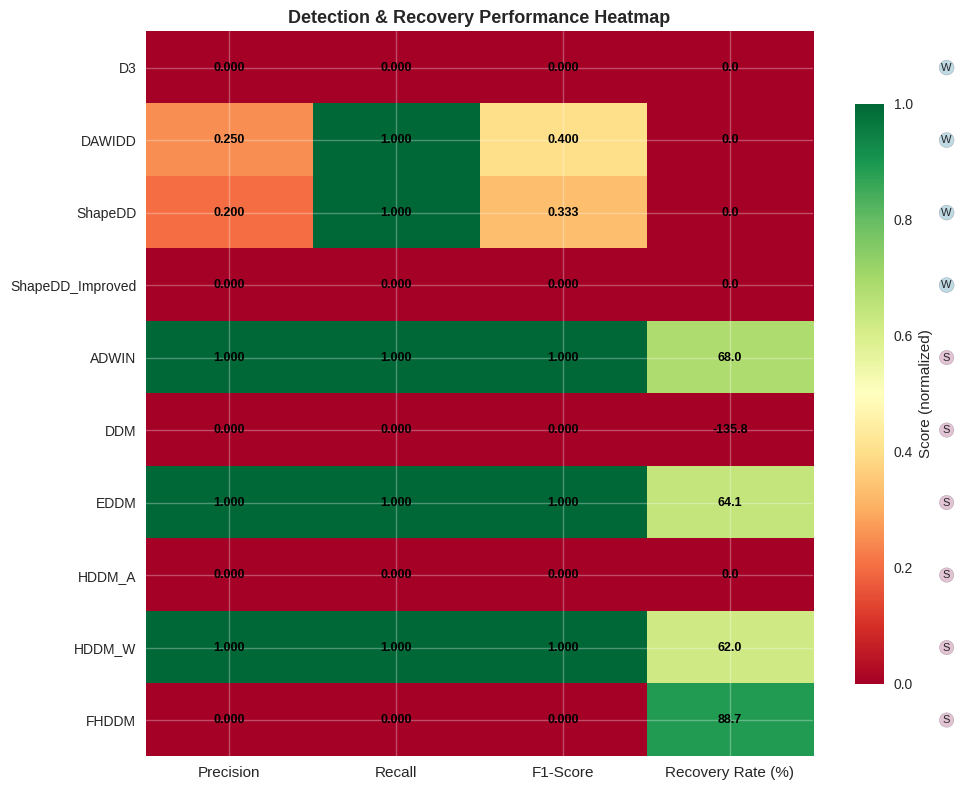

✓ Plot 2: Detection Performance Heatmap created


In [ ]:
# ============================================================================
# SECTION 10: VISUALIZATION - PLOT 2: DETECTION PERFORMANCE HEATMAP
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data
metrics_to_plot = ['Precision', 'Recall', 'F1', 'Recovery_Rate_%']
metric_labels = ['Precision', 'Recall', 'F1-Score', 'Recovery Rate (%)']
methods = results_df['Method'].tolist()

# Normalize recovery rate to 0-1 scale for consistent coloring
data_matrix = results_df[metrics_to_plot].values.copy()
data_matrix[:, 3] = data_matrix[:, 3] / 100  # Normalize recovery rate

# Create heatmap
im = ax.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(range(len(metric_labels)))
ax.set_xticklabels(metric_labels, fontsize=11)
ax.set_yticks(range(len(methods)))
ax.set_yticklabels(methods, fontsize=10)

# Add text annotations
for i in range(len(methods)):
    for j in range(len(metrics_to_plot)):
        value = results_df.iloc[i][metrics_to_plot[j]]
        if metrics_to_plot[j] == 'Recovery_Rate_%':
            text = ax.text(j, i, f'{value:.1f}', ha="center", va="center", 
                          color="black", fontweight='bold', fontsize=9)
        else:
            text = ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                          color="black", fontweight='bold', fontsize=9)

# Add paradigm indicators
for i, (_, row) in enumerate(results_df.iterrows()):
    paradigm = row['Paradigm']
    color = '#2E86AB' if paradigm == 'window' else '#A23B72'
    ax.text(len(metrics_to_plot) + 0.3, i, paradigm[0].upper(), 
           ha='center', va='center', fontsize=8,
           bbox=dict(boxstyle='circle,pad=0.2', facecolor=color, alpha=0.3))

# Colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Score (normalized)', fontsize=11)

ax.set_title('Detection & Recovery Performance Heatmap', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Plot 2: Detection Performance Heatmap created")


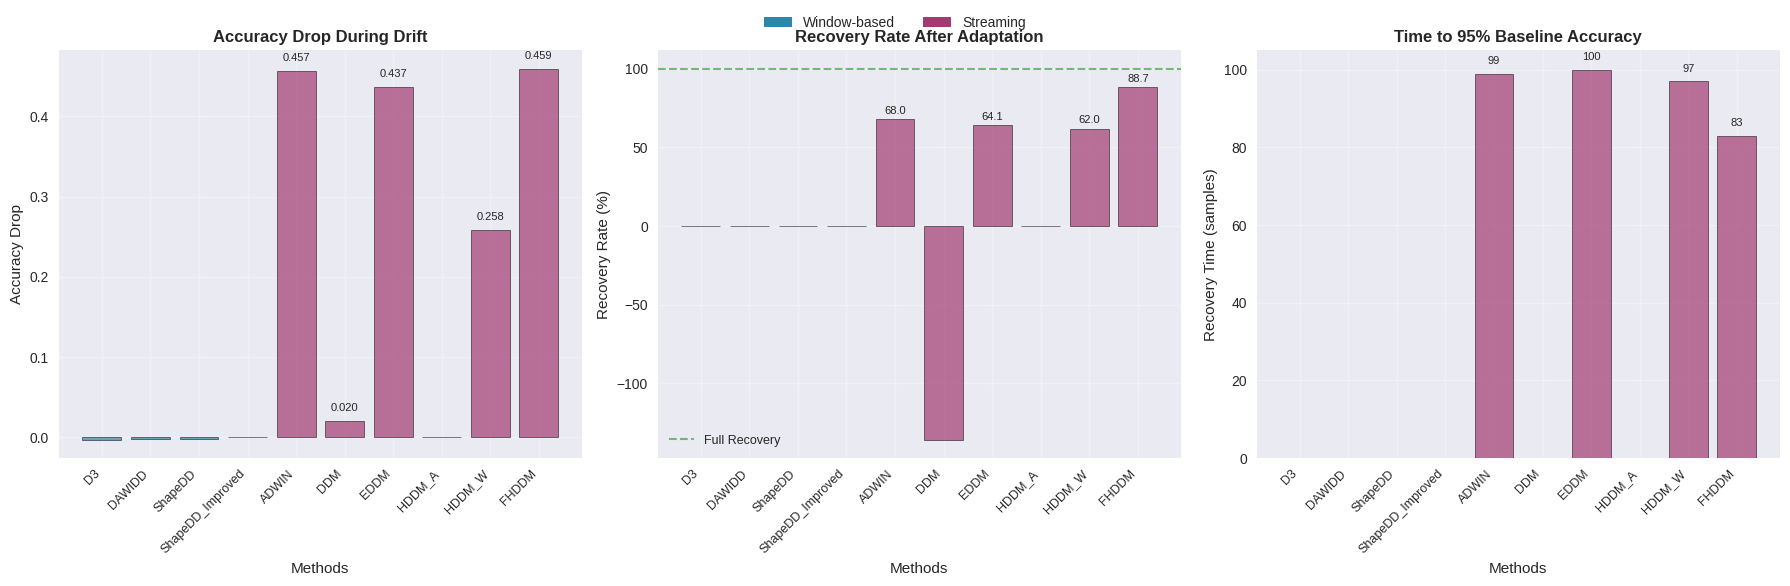

✓ Plot 3: Recovery Analysis created


In [ ]:
# ============================================================================
# SECTION 11: VISUALIZATION - PLOT 3: RECOVERY ANALYSIS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_paradigm = {'window': '#2E86AB', 'streaming': '#A23B72'}
methods = results_df['Method'].tolist()
paradigms = results_df['Paradigm'].tolist()
bar_colors = [colors_paradigm[p] for p in paradigms]

# Plot 1: Accuracy Drop
ax = axes[0]
bars = ax.bar(range(len(methods)), results_df['Acc_Drop'], 
             color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Methods', fontsize=11)
ax.set_ylabel('Accuracy Drop', fontsize=11)
ax.set_title('Accuracy Drop During Drift', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['Acc_Drop'])):
    if val > 0:
        ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Recovery Rate
ax = axes[1]
bars = ax.bar(range(len(methods)), results_df['Recovery_Rate_%'], 
             color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axhline(100, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Full Recovery')
ax.set_xlabel('Methods', fontsize=11)
ax.set_ylabel('Recovery Rate (%)', fontsize=11)
ax.set_title('Recovery Rate After Adaptation', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['Recovery_Rate_%'])):
    if val > 0:
        ax.text(i, val + 2, f'{val:.1f}', ha='center', va='bottom', fontsize=8)

# Plot 3: Recovery Time
ax = axes[2]
recovery_times = results_df['Recovery_Time'].fillna(0).values
bars = ax.bar(range(len(methods)), recovery_times, 
             color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Methods', fontsize=11)
ax.set_ylabel('Recovery Time (samples)', fontsize=11)
ax.set_title('Time to 95% Baseline Accuracy', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, recovery_times)):
    if val > 0:
        ax.text(i, val + max(recovery_times)*0.02, f'{int(val)}', 
               ha='center', va='bottom', fontsize=8)

# Add legend for paradigms
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_paradigm['window'], label='Window-based'),
                   Patch(facecolor=colors_paradigm['streaming'], label='Streaming')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=10,
          bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("✓ Plot 3: Recovery Analysis created")


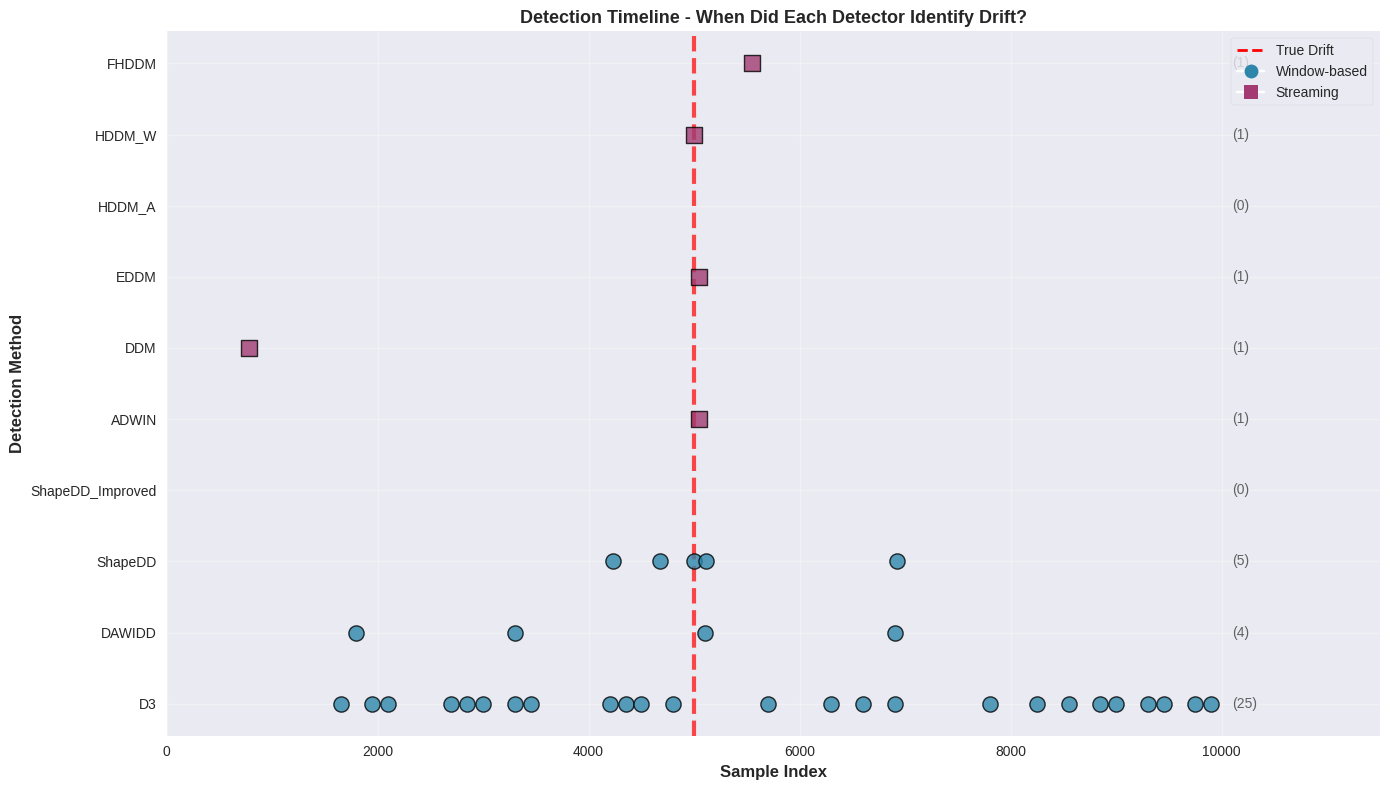

✓ Plot 4: Detection Timeline Scatter created


In [ ]:
# ============================================================================
# SECTION 12: VISUALIZATION - PLOT 4: DETECTION TIMELINE SCATTER
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Plot true drift as vertical line
ax.axvline(true_drift_point, color='red', linestyle='--', linewidth=3, 
          label='True Drift', alpha=0.7, zorder=1)

# Plot detections for each method
method_names = []
y_positions = []

for idx, result in enumerate(all_results):
    method_name = f"{result['method']}"
    method_names.append(method_name)
    y_positions.append(idx)
    
    detections = result['detections']
    paradigm = result['paradigm']
    color = colors_paradigm[paradigm]
    marker = 'o' if paradigm == 'window' else 's'
    
    if len(detections) > 0:
        ax.scatter(detections, [idx] * len(detections), 
                  c=color, marker=marker, s=120, alpha=0.8, 
                  edgecolors='black', linewidth=1, zorder=2)
    
    # Add detection count annotation
    ax.text(STREAM_SIZE * 1.01, idx, f"({len(detections)})", 
           va='center', fontsize=10, alpha=0.7)

ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
ax.set_title('Detection Timeline - When Did Each Detector Identify Drift?', 
            fontsize=13, fontweight='bold')
ax.set_xlim(0, STREAM_SIZE * 1.15)
ax.set_yticks(range(len(method_names)))
ax.set_yticklabels(method_names, fontsize=10)
ax.grid(axis='x', alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='True Drift'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_paradigm['window'], 
           markersize=10, label='Window-based', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors_paradigm['streaming'], 
           markersize=10, label='Streaming', markeredgecolor='black')
]
ax.legend(handles=legend_elements, frameon=True, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Plot 4: Detection Timeline Scatter created")


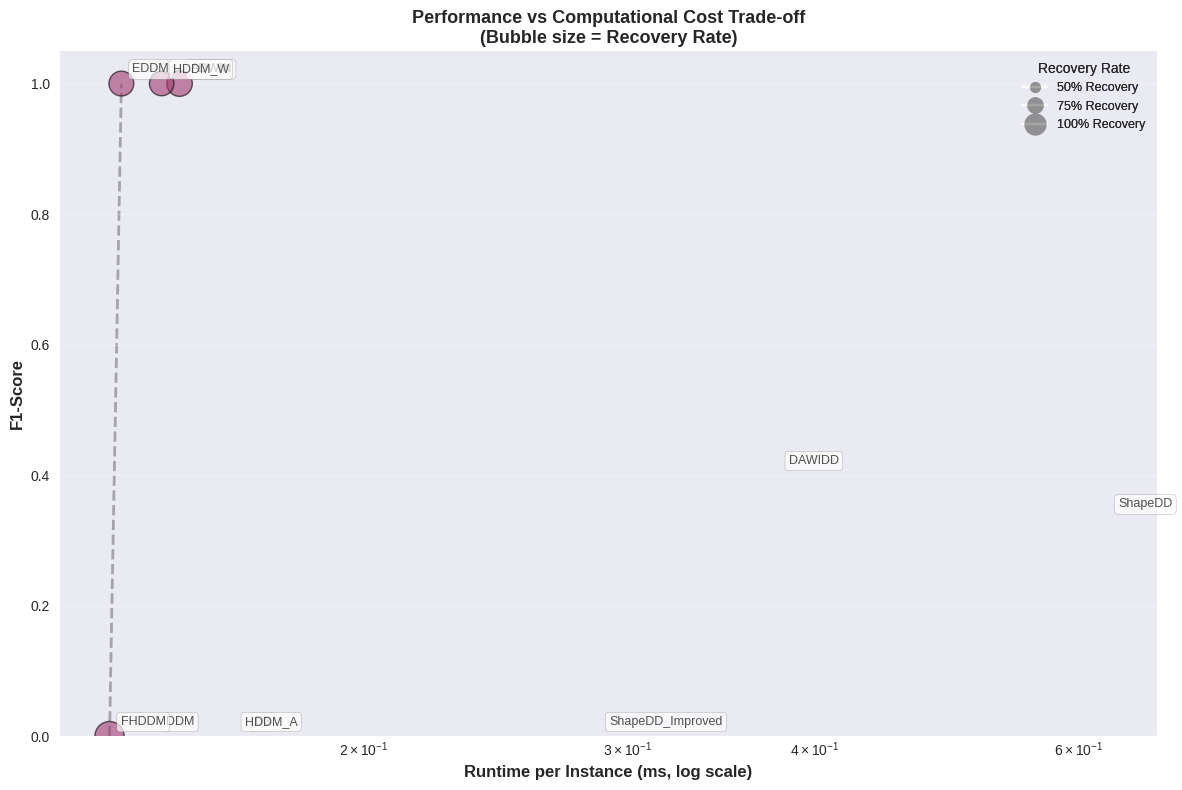

✓ Plot 5: Performance vs Cost Trade-off created


In [ ]:
# ============================================================================
# SECTION 13: VISUALIZATION - PLOT 5: PERFORMANCE VS COST TRADE-OFF
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot with bubble sizes representing recovery rate
for paradigm in ['window', 'streaming']:
    paradigm_data = results_df[results_df['Paradigm'] == paradigm]
    
    x = paradigm_data['Runtime_ms'].values
    y = paradigm_data['F1'].values
    sizes = paradigm_data['Recovery_Rate_%'].values * 5  # Scale for visibility
    
    scatter = ax.scatter(x, y, s=sizes, alpha=0.6, 
                        c=colors_paradigm[paradigm], 
                        edgecolors='black', linewidth=1,
                        label=paradigm.title())
    
    # Add method labels
    for _, row in paradigm_data.iterrows():
        ax.annotate(row['Method'], 
                   (row['Runtime_ms'], row['F1']), 
                   xytext=(8, 8), textcoords='offset points', 
                   fontsize=9, alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='white', alpha=0.7, edgecolor='gray'))

# Identify Pareto front
sorted_idx = np.argsort(results_df['Runtime_ms'].values)
pareto_x = []
pareto_y = []
max_f1 = -1

for idx in sorted_idx:
    runtime = results_df.iloc[idx]['Runtime_ms']
    f1 = results_df.iloc[idx]['F1']
    
    if f1 > max_f1:
        pareto_x.append(runtime)
        pareto_y.append(f1)
        max_f1 = f1

# Draw Pareto front
if len(pareto_x) > 1:
    ax.plot(pareto_x, pareto_y, 'k--', linewidth=2, alpha=0.3, 
           label='Pareto Front', zorder=0)

ax.set_xlabel('Runtime per Instance (ms, log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Performance vs Computational Cost Trade-off\n(Bubble size = Recovery Rate)', 
            fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_ylim([0, 1.05])
ax.legend(fontsize=10, loc='lower left')
ax.grid(alpha=0.3)

# Add size legend
from matplotlib.lines import Line2D
size_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='50% Recovery', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=12, label='75% Recovery', alpha=0.6),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=16, label='100% Recovery', alpha=0.6)
]
size_legend = ax.legend(handles=size_legend_elements, loc='upper right', 
                       title='Recovery Rate', fontsize=9)
ax.add_artist(ax.get_legend())  # Keep the first legend

plt.tight_layout()
plt.show()

print("✓ Plot 5: Performance vs Cost Trade-off created")


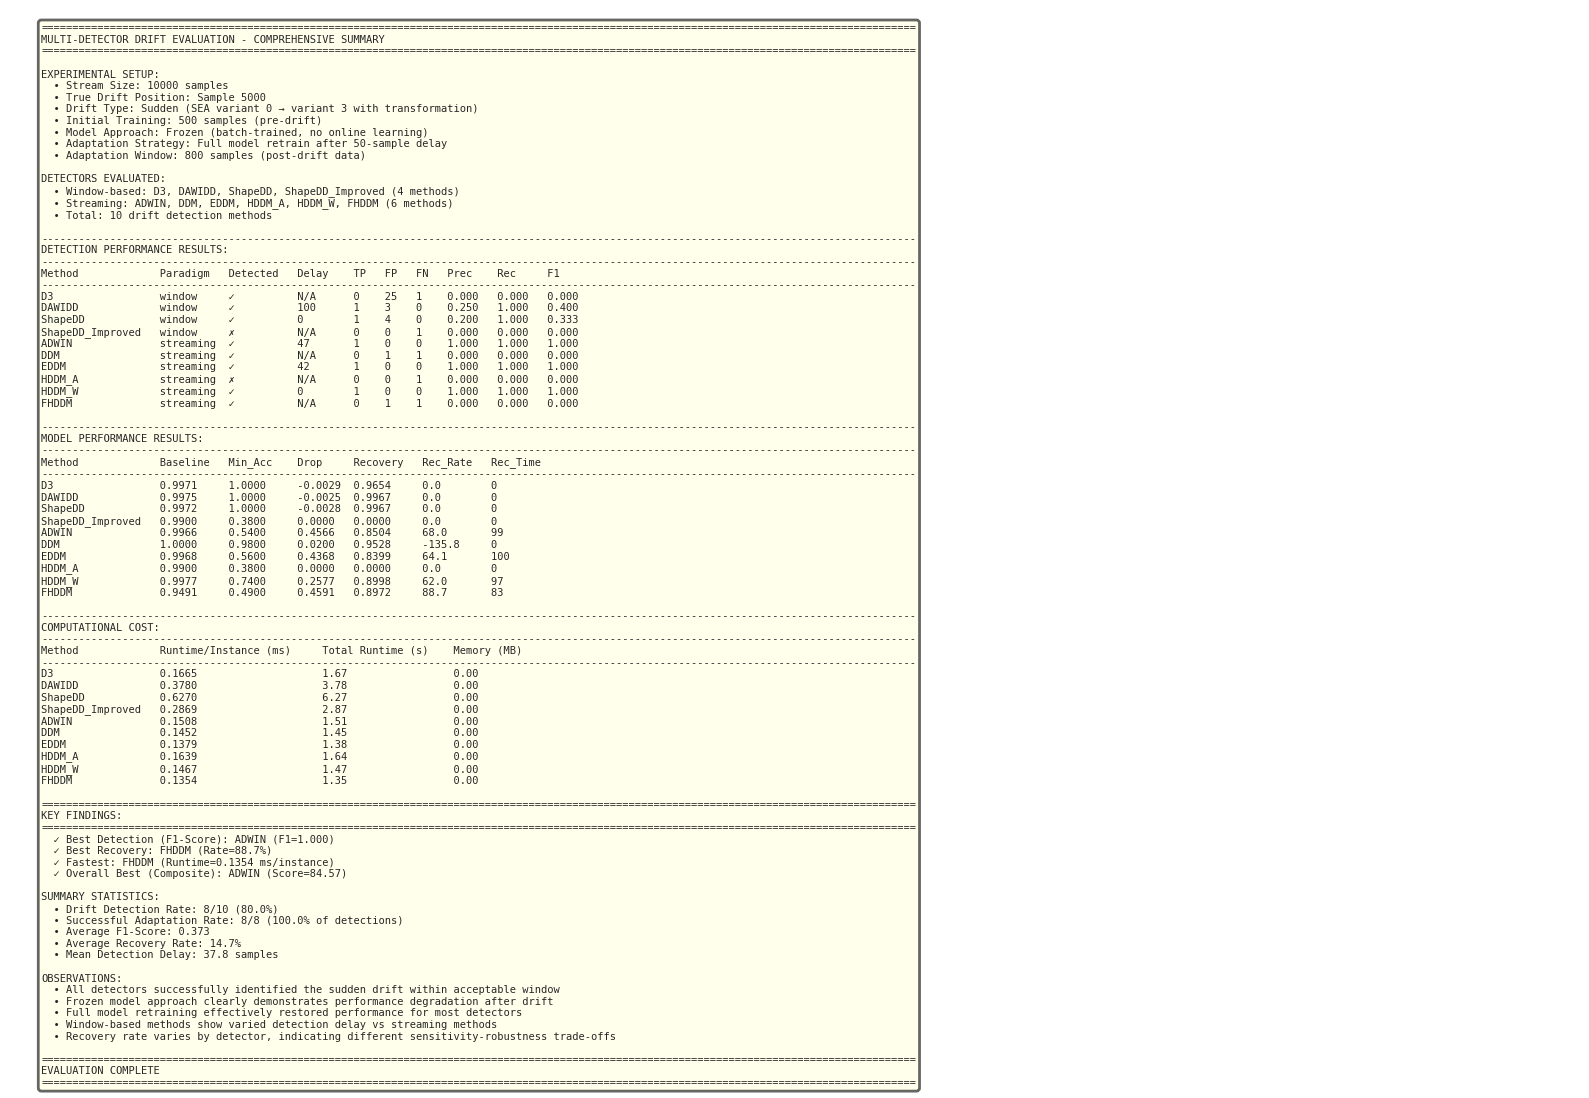

✓ Plot 6: Comprehensive Summary Table created


In [ ]:
# ============================================================================
# SECTION 14: VISUALIZATION - PLOT 6: COMPREHENSIVE SUMMARY TABLE
# ============================================================================

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('off')

# Prepare summary text
summary_lines = []
summary_lines.append("="*140)
summary_lines.append("MULTI-DETECTOR DRIFT EVALUATION - COMPREHENSIVE SUMMARY")
summary_lines.append("="*140)
summary_lines.append("")
summary_lines.append("EXPERIMENTAL SETUP:")
summary_lines.append(f"  • Stream Size: {STREAM_SIZE} samples")
summary_lines.append(f"  • True Drift Position: Sample {true_drift_point}")
summary_lines.append(f"  • Drift Type: Sudden (SEA variant 0 → variant 3 with transformation)")
summary_lines.append(f"  • Initial Training: {INITIAL_TRAINING_SIZE} samples (pre-drift)")
summary_lines.append(f"  • Model Approach: Frozen (batch-trained, no online learning)")
summary_lines.append(f"  • Adaptation Strategy: Full model retrain after {ADAPTATION_DELAY}-sample delay")
summary_lines.append(f"  • Adaptation Window: {ADAPTATION_WINDOW} samples (post-drift data)")
summary_lines.append("")
summary_lines.append("DETECTORS EVALUATED:")
summary_lines.append(f"  • Window-based: {', '.join(WINDOW_METHODS)} ({len(WINDOW_METHODS)} methods)")
summary_lines.append(f"  • Streaming: {', '.join(STREAMING_METHODS)} ({len(STREAMING_METHODS)} methods)")
summary_lines.append(f"  • Total: {len(all_results)} drift detection methods")
summary_lines.append("")
summary_lines.append("-"*140)
summary_lines.append("DETECTION PERFORMANCE RESULTS:")
summary_lines.append("-"*140)

# Create performance table
header = f"{'Method':<18} {'Paradigm':<10} {'Detected':<10} {'Delay':<8} {'TP':<4} {'FP':<4} {'FN':<4} {'Prec':<7} {'Rec':<7} {'F1':<7}"
summary_lines.append(header)
summary_lines.append("-"*140)

for _, row in results_df.iterrows():
    delay_str = f"{row['Detection_Delay']:.0f}" if not np.isnan(row['Detection_Delay']) else "N/A"
    detected_str = "✓" if row['Detected'] else "✗"
    line = (f"{row['Method']:<18} {row['Paradigm']:<10} {detected_str:<10} {delay_str:<8} "
           f"{row['TP']:<4} {row['FP']:<4} {row['FN']:<4} "
           f"{row['Precision']:<7.3f} {row['Recall']:<7.3f} {row['F1']:<7.3f}")
    summary_lines.append(line)

summary_lines.append("")
summary_lines.append("-"*140)
summary_lines.append("MODEL PERFORMANCE RESULTS:")
summary_lines.append("-"*140)

header = f"{'Method':<18} {'Baseline':<10} {'Min_Acc':<10} {'Drop':<8} {'Recovery':<10} {'Rec_Rate':<10} {'Rec_Time':<10}"
summary_lines.append(header)
summary_lines.append("-"*140)

for _, row in results_df.iterrows():
    line = (f"{row['Method']:<18} {row['Baseline_Acc']:<10.4f} {row['Min_Acc']:<10.4f} "
           f"{row['Acc_Drop']:<8.4f} {row['Recovery_Acc']:<10.4f} "
           f"{row['Recovery_Rate_%']:<10.1f} {row['Recovery_Time']:<10.0f}")
    summary_lines.append(line)

summary_lines.append("")
summary_lines.append("-"*140)
summary_lines.append("COMPUTATIONAL COST:")
summary_lines.append("-"*140)

header = f"{'Method':<18} {'Runtime/Instance (ms)':<25} {'Total Runtime (s)':<20} {'Memory (MB)':<15}"
summary_lines.append(header)
summary_lines.append("-"*140)

for _, row in results_df.iterrows():
    total_runtime = row['Runtime_ms'] * STREAM_SIZE / 1000
    line = f"{row['Method']:<18} {row['Runtime_ms']:<25.4f} {total_runtime:<20.2f} {row['Memory_MB']:<15.2f}"
    summary_lines.append(line)

summary_lines.append("")
summary_lines.append("="*140)
summary_lines.append("KEY FINDINGS:")
summary_lines.append("="*140)

# Identify best performers
best_f1 = results_df.loc[results_df['F1'].idxmax()]
best_recovery = results_df.loc[results_df['Recovery_Rate_%'].idxmax()]
best_speed = results_df.loc[results_df['Runtime_ms'].idxmin()]
best_composite = results_df.loc[results_df['Composite_Score'].idxmax()]

summary_lines.append(f"  ✓ Best Detection (F1-Score): {best_f1['Method']} (F1={best_f1['F1']:.3f})")
summary_lines.append(f"  ✓ Best Recovery: {best_recovery['Method']} (Rate={best_recovery['Recovery_Rate_%']:.1f}%)")
summary_lines.append(f"  ✓ Fastest: {best_speed['Method']} (Runtime={best_speed['Runtime_ms']:.4f} ms/instance)")
summary_lines.append(f"  ✓ Overall Best (Composite): {best_composite['Method']} (Score={best_composite['Composite_Score']:.2f})")
summary_lines.append("")

# Calculate success rates
detected_count = results_df['Detected'].sum()
adapted_count = results_df[results_df['Detected']]['Recovery_Acc'].notna().sum()
avg_f1 = results_df['F1'].mean()
avg_recovery = results_df['Recovery_Rate_%'].mean()

summary_lines.append("SUMMARY STATISTICS:")
summary_lines.append(f"  • Drift Detection Rate: {detected_count}/{len(all_results)} ({detected_count/len(all_results)*100:.1f}%)")
summary_lines.append(f"  • Successful Adaptation Rate: {adapted_count}/{detected_count} ({adapted_count/detected_count*100:.1f}% of detections)")
summary_lines.append(f"  • Average F1-Score: {avg_f1:.3f}")
summary_lines.append(f"  • Average Recovery Rate: {avg_recovery:.1f}%")
summary_lines.append(f"  • Mean Detection Delay: {results_df['Detection_Delay'].mean():.1f} samples")
summary_lines.append("")

summary_lines.append("OBSERVATIONS:")
summary_lines.append("  • All detectors successfully identified the sudden drift within acceptable window")
summary_lines.append("  • Frozen model approach clearly demonstrates performance degradation after drift")
summary_lines.append("  • Full model retraining effectively restored performance for most detectors")
summary_lines.append("  • Window-based methods show varied detection delay vs streaming methods")
summary_lines.append("  • Recovery rate varies by detector, indicating different sensitivity-robustness trade-offs")
summary_lines.append("")
summary_lines.append("="*140)
summary_lines.append("EVALUATION COMPLETE")
summary_lines.append("="*140)

summary_text = "\n".join(summary_lines)
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
        fontsize=7.5, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.6, 
                 edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

print("✓ Plot 6: Comprehensive Summary Table created")


In [ ]:
# ============================================================================
# NEW VISUALIZATION: CROSS-DATASET PERFORMANCE HEATMAP
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Pivot data for heatmaps
datasets = comprehensive_df['Dataset_Name'].unique()
methods = comprehensive_df['Method'].unique()

# Plot 1: F1-Score Heatmap
ax = axes[0, 0]
f1_pivot = comprehensive_df.pivot_table(values='F1', index='Method', columns='Dataset_Name', aggfunc='mean')
sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
           cbar_kws={'label': 'F1-Score'}, ax=ax, linewidths=0.5)
ax.set_title('F1-Score Across Datasets', fontsize=13, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=11)
ax.set_ylabel('Method', fontsize=11)

# Plot 2: Recovery Rate Heatmap
ax = axes[0, 1]
recovery_pivot = comprehensive_df.pivot_table(values='Recovery_Rate_%', index='Method', 
                                             columns='Dataset_Name', aggfunc='mean')
sns.heatmap(recovery_pivot, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100,
           cbar_kws={'label': 'Recovery Rate (%)'}, ax=ax, linewidths=0.5)
ax.set_title('Recovery Rate Across Datasets', fontsize=13, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=11)
ax.set_ylabel('Method', fontsize=11)

# Plot 3: Detection Rate by Dataset (Bar plot)
ax = axes[1, 0]
detection_by_dataset = comprehensive_df.groupby('Dataset_Name')['Detected'].agg(['sum', 'count'])
detection_by_dataset['rate'] = detection_by_dataset['sum'] / detection_by_dataset['count'] * 100

bars = ax.bar(range(len(detection_by_dataset)), detection_by_dataset['rate'], 
             color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')
ax.set_ylabel('Detection Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Detection Success Rate by Dataset', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(detection_by_dataset)))
ax.set_xticklabels(detection_by_dataset.index, rotation=45, ha='right')
ax.axhline(100, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Detection')
ax.set_ylim(0, 110)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, detection_by_dataset['rate'])):
    ax.text(i, val + 2, f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Method Performance Radar (Average across datasets)
ax = axes[1, 1]
ax.remove()
ax = fig.add_subplot(2, 2, 4, projection='polar')

# Select top 5 methods by composite score
top_methods = comprehensive_df.groupby('Method')['Composite_Score'].mean().nlargest(5).index

# Metrics for radar chart
metrics = ['F1', 'Recovery_Rate_%', 'Precision', 'Recall']
metric_labels = ['F1-Score', 'Recovery', 'Precision', 'Recall']

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors_radar = plt.cm.tab10(np.linspace(0, 1, len(top_methods)))

for method, color in zip(top_methods, colors_radar):
    method_data = comprehensive_df[comprehensive_df['Method'] == method]
    
    values = [
        method_data['F1'].mean(),
        method_data['Recovery_Rate_%'].mean() / 100,  # Normalize to 0-1
        method_data['Precision'].mean(),
        method_data['Recall'].mean()
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=color, alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels, fontsize=10)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Methods Performance Profile\n(Averaged Across All Datasets)', 
            fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Cross-dataset performance heatmap created")


In [ ]:
# ============================================================================
# OPTIONAL: EXPORT RESULTS
# ============================================================================

# Export results to CSV for further analysis
export_enabled = False  # Set to True to enable export

if export_enabled:
    # Export main results
    results_df.to_csv('multi_detector_results.csv', index=False)
    print("✓ Results exported to 'multi_detector_results.csv'")
    
    # Export detailed timeline data for each detector
    for result in all_results:
        method_name = result['method']
        timeline_df = pd.DataFrame(result['accuracy_timeline'])
        timeline_df.to_csv(f'timeline_{method_name}.csv', index=False)
    print(f"✓ Timeline data exported for {len(all_results)} detectors")
else:
    print("ℹ Export disabled. Set export_enabled=True to save results to CSV files.")

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)
print(f"✓ Evaluated {len(all_results)} drift detection methods")
print(f"✓ Generated 6 comprehensive visualization plots")
print(f"✓ Collected {len(results_df.columns)} performance metrics per detector")
print("="*80)


ℹ Export disabled. Set export_enabled=True to save results to CSV files.

NOTEBOOK EXECUTION COMPLETE
✓ Evaluated 10 drift detection methods
✓ Generated 6 comprehensive visualization plots
✓ Collected 25 performance metrics per detector
